# **PCA: Análisis de Componentes Principales.**

El Análisis de Componentes Principales (PCA) es una técnica estadística utilizada para reducir la dimensionalidad de un conjunto de datos, preservando la mayor cantidad de variabilidad posible. Matemáticamente, PCA transforma un conjunto de variables posiblemente correlacionadas en un conjunto de variables linealmente no correlacionadas llamadas componentes principales.

A continuación, se presenta un ejemplo detallado de cómo realizar PCA desde un enfoque matemático.

**Supuestos del Ejemplo.** Supongamos que tenemos un conjunto de datos con dos variables para simplificar el ejemplo:
- Variable X: Representa alguna medida **cuantitativa** (por ejemplo, altura).
- Variable Y: Representa otra medida **cuantitativa** (por ejemplo, peso).

# **Caso de Ejemplo: Caso Tiroides.**
La estandarización es un paso crucial en el Análisis de Componentes Principales (PCA). Consiste en transformar las variables originales para que tengan una **media de 0 y una desviación estándar de 1**. Esto es importante porque PCA es **sensible a las escalas de las variables**; variables con escalas mayores dominarán la formación de las componentes principales si no se estandarizan.

La estandarización asegura que todas las variables contribuyan de manera equitativa al análisis de PCA, evitando que variables con escalas mayores dominen las componentes principales simplemente debido a su escala.

La varianza explicada por una componente principal indica la proporción de la variabilidad total en los datos que esa componente captura. Es una medida de cuán representativa es la componente respecto a los datos originales.

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Configuración de estilos para visualización.
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
# Seteo de opciones para mostrar todas las columnas.
pd.set_option('display.max_columns', None)

In [242]:
df = pd.read_csv('data/thyroidDF.csv', delimiter=';')
df.head()

age  on_1hyroxine  query_on_1hyroxine  on_an1i1hyroid_meds  sick  pregnan1  \
0   29             0                   0                    0     0         0   
1   28             0                   0                    0     0         0   
2   28             0                   0                    0     0         0   
3   28             0                   0                    0     0         0   
4   54             0                   0                    0     0         0   

   1hyroid_surgery  I131_1rea1men1  query_hypo1hyroid  query_hyper1hyroid  \
0                0               0                  0                   0   
1                0               0                  0                   0   
2                0               0                  0                   0   
3                0               0                  0                   0   
4                0               0                  0                   0   

   li1hium  goi1re  1umor  hypopi1ui1ary  psych  target_thyro   T3    TT4  \
0        0       0      0              0      0             0  1.9  128.0   
1        0       0      0              0      0             0  2.6  116.0   
2        0       0      0              0      0             0  1.8   76.0   
3        0       0      0              0      0             0  1.7   83.0   
4        0       0      0              0      0             0  2.3  133.0   

   T4U  FTI  TBG referral_source  patient_id  
0  0.0  0.0    0           other   840801014  
1  0.0  0.0    0             SVI   840807019  
2  0.0  0.0    0           other   840808060  
3  0.0  0.0    0           other   840808073  
4  0.0  0.0    0           other   840810016

## **Tratamiento de variables antes de aplicar PCA.**
Antes de aplicar PCA, es importante asegurarse de que las variables estén en un formato adecuado. A continuación se detalla cómo tratar las variables categóricas y binarias:
1. **Variables categóricas:** No pueden utilizarse directamente. Se deben transformar utilizando:
   - **One-Hot Encoding:** Crea una nueva variable binaria para cada categoría. Es la opción recomendada cuando las categorías no tienen un orden implícito.
   - **Codificación ordinal (solo si hay orden):** Asigna valores numéricos a las categorías según su jerarquía.

2. **Variables binarias (0 y 1):**
   - Si representan una categoría (por ejemplo, “sí/no”, “masculino/femenino”), **pueden mantenerse** en el análisis porque son variables numéricas. Sin embargo, es importante tener en cuenta que las variables binarias suelen tener una **varianza muy baja** si la mayoría de los registros pertenecen a una misma categoría (por ejemplo, si el 95 % de los valores son 1 y solo el 5 % son 0).
   - Cuando una variable tiene muy poca variación, **su aporte al PCA será mínimo** y puede incluso **generar ruido** en el modelo. En estos casos, se recomienda:
     - Revisar la **distribución de valores** de cada variable binaria.
     - **Eliminar aquellas con varianza cercana a cero**, ya que no aportan información útil.
     - Si se han generado muchas variables binarias a partir de una variable categórica (como ocurre con One-Hot Encoding), considerar aplicar **técnicas de reducción de dimensionalidad** adicionales o **agrupar categorías similares** si es viable desde el punto de vista del negocio o del análisis.

Una vez transformadas todas las variables a formato numérico, es fundamental **escalar** los datos (`StandardScaler`) para que todas las variables contribuyan por igual al PCA.

In [243]:
# Selección de columnas numéricas.
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('patient_id')
print("Columnas numéricas:", numerical_cols)

Columnas numéricas: ['age', 'on_1hyroxine', 'query_on_1hyroxine', 'on_an1i1hyroid_meds', 'sick', 'pregnan1', '1hyroid_surgery', 'I131_1rea1men1', 'query_hypo1hyroid', 'query_hyper1hyroid', 'li1hium', 'goi1re', '1umor', 'hypopi1ui1ary', 'psych', 'target_thyro', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']


In [244]:
# Identificación de variables binarias y continuas.
binary_cols = []
continuous_cols = []

for col in numerical_cols:
    unique_values = df[col].dropna().unique()
    if sorted(unique_values) == [0, 1]:
        binary_cols.append(col)
    else:
        continuous_cols.append(col)

print("Variables continuas seleccionadas para PCA:", continuous_cols)

Variables continuas seleccionadas para PCA: ['age', 'hypopi1ui1ary', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']


In [245]:
# Selección solo de las variables numéricas continuas.
df_continuous = df[continuous_cols]

# Manejo de valores faltantes.
df_cleaned = df_continuous.dropna()

# Estandarización de las variables numéricas.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)
df_scaled = pd.DataFrame(X_scaled, columns=continuous_cols)
df_scaled.head()

age  hypopi1ui1ary        T3       TT4       T4U       FTI       TBG
0 -1.246131            0.0  0.499894  0.841120 -3.180013 -2.457592 -0.061952
1 -1.298241            0.0  1.193645  0.467430 -3.180013 -2.457592 -0.061952
2 -1.298241            0.0  0.400787 -0.778203 -3.180013 -2.457592 -0.061952
3 -1.298241            0.0  0.301680 -0.560217 -3.180013 -2.457592 -0.061952
4  0.056598            0.0  0.896323  0.996824 -3.180013 -2.457592 -0.061952

Aplicamos el **Análisis de Componentes Principales (PCA)** a los datos previamente escalados, reduciendo la dimensionalidad a **dos componentes principales** para facilitar la visualización y el análisis posterior.

In [246]:
# Aplicación PCA.
n_components = 2  # Puedes ajustar este número según necesidades.
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components+1)])

# Obtener todos los puntos del PCA.
pca_points = pca_df.values.tolist()

Calculamos la proporción de **varianza explicada por cada componente principal**. Esto nos indica cuánta información (variabilidad) de los datos originales se conserva en cada componente.

In [247]:
# Varianza explicada.
varianza_explicada = pca.explained_variance_ratio_
for i, var in enumerate(varianza_explicada, start=1):
    print(f"PC{i}: {var*100:.2f}%")
print(f"Varianza total explicada: {sum(varianza_explicada)*100:.2f}%")

PC1: 31.23%
PC2: 18.50%
Varianza total explicada: 49.73%


**Conclusión.**
- PC1 explica el 31.23% de la varianza total del dataset.
- PC2 explica el 18.50% de la varianza adicional.
Juntas explican el 49.73% de la varianza, lo que indica que **estas dos dimensiones capturan casi la mitad de la información** del conjunto de datos.

Representamos gráficamente los datos en el nuevo espacio bidimensional definido por las dos primeras componentes principales. Esto permite observar patrones o agrupaciones en los datos.

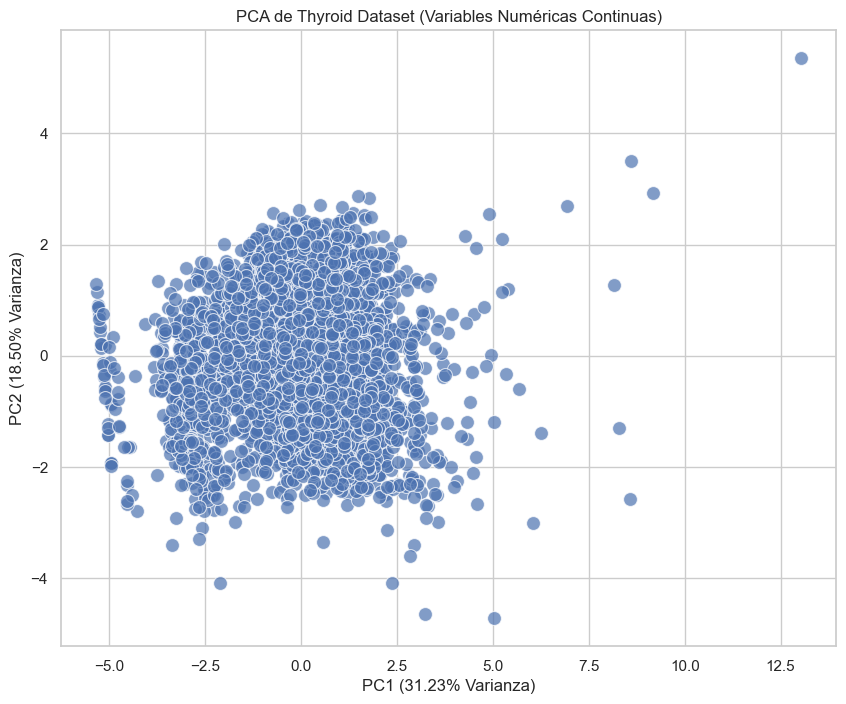

In [248]:
# Visualización: Scatter Plot.
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, alpha=0.7)
plt.title('PCA de Thyroid Dataset (Variables Numéricas Continuas)')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

Visualizamos el PCA junto con los **vectores de carga de las variables originales**. Esto ayuda a interpretar cómo influyen las variables en la formación de las componentes principales. **Cuanto más larga y alineada esté una flecha con una componente, mayor es su contribución**. Además, la dirección de los vectores permite identificar relaciones entre variables: **si apuntan en la misma dirección, están correlacionadas positivamente; si son opuestas, la correlación es negativa**.

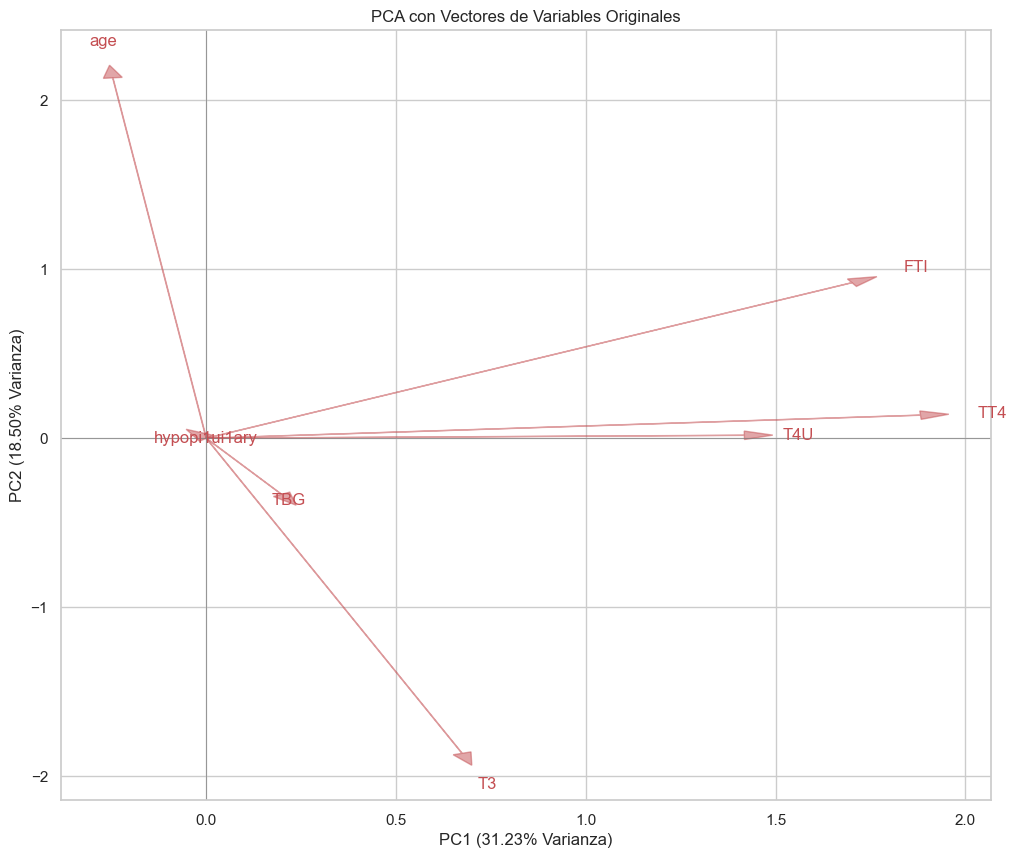

In [249]:
# Visualización: Biplot.
cargas = pca.components_.T
escalamiento = 3  # Ajusta este valor según los datos --> ampliar las flechas de los vectores.
cargas_scaled = cargas * escalamiento

plt.figure(figsize=(12,10))

for i, var in enumerate(continuous_cols):
    plt.arrow(0, 0, cargas_scaled[i,0], cargas_scaled[i,1], 
              color='r', alpha=0.5, head_width=0.05)
    plt.text(cargas_scaled[i,0]*1.1, cargas_scaled[i,1]*1.1, 
             var, color='r', ha='center', va='center')

plt.title('PCA con Vectores de Variables Originales')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()

Mostramos una tabla que indica cuánto contribuye cada variable original a las nuevas componentes principales. Esta información es útil para interpretar el **significado de cada componente** y entender **qué variables tienen mayor peso en la proyección de los datos**. Las cargas funcionan como coeficientes en las combinaciones lineales del PCA, por lo que **valores altos (positivos o negativos) indican una fuerte influencia** de esa variable en la componente correspondiente. Esto permite interpretar, por ejemplo, si una componente refleja principalmente variabilidad relacionada con ciertas funciones biológicas, hábitos o factores médicos, dependiendo del contexto de las variables.

In [250]:
# Definir las cargas antes de los gráficos.
cargas_df = pd.DataFrame(cargas, index=continuous_cols, columns=['PC1', 'PC2'])
print("Cargas de las variables en las componentes principales:")
cargas_df

Cargas de las variables en las componentes principales:


PC1           PC2
age           -8.207457e-02  7.108570e-01
hypopi1ui1ary -1.110223e-16  1.110223e-16
T3             2.246924e-01 -6.214653e-01
TT4            6.272799e-01  4.554097e-02
T4U            4.726076e-01  5.836922e-03
FTI            5.670667e-01  3.067922e-01
TBG            6.613891e-02 -1.106058e-01

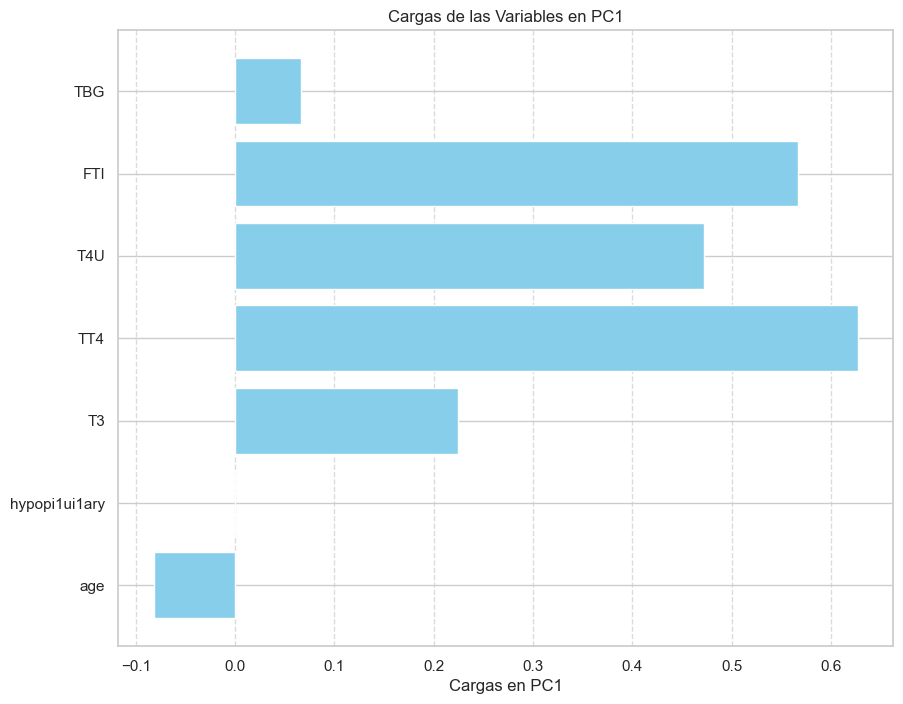

In [251]:
# Gráfico de Cargas para PC1.
plt.figure(figsize=(10,8))
plt.barh(cargas_df.index, cargas_df['PC1'], color='skyblue')
plt.xlabel('Cargas en PC1')
plt.title('Cargas de las Variables en PC1')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

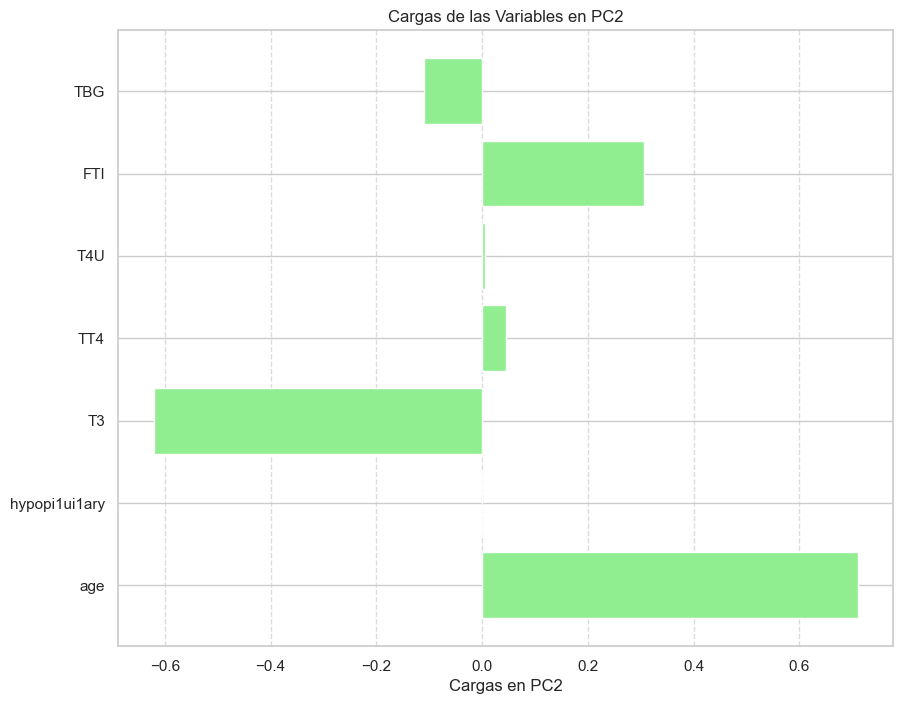

In [252]:
# Gráfico de Cargas para PC2.
plt.figure(figsize=(10,8))
plt.barh(cargas_df.index, cargas_df['PC2'], color='lightgreen')
plt.xlabel('Cargas en PC2')
plt.title('Cargas de las Variables en PC2')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

**Conclusiones de las Cargas.** Las cargas indican cuánto influye cada variable en una componente principal.
- **PC1 (31.23% de la varianza):**
    - TT4 (0.627), FTI (0.567) y T4U (0.472) tienen cargas altas y positivas: Esta componente está dominada por mediciones hormonales de la tiroides.
    - T3 (0.225) también contribuye, pero menos que TT4 y FTI.
    - Edad (-0.082) tiene un impacto leve y negativo.
    - **Interpretación:** PC1 parece representar el estado hormonal tiroideo.

- **PC2 (18.50% de la varianza)**
    - Edad (0.711) tiene una carga muy fuerte en esta componente: Indica que la edad es una variable clave en PC2.
    - T3 (-0.621) tiene una carga negativa significativa.
    - Otras hormonas (TT4, FTI, T4U, TBG) tienen cargas menores.
    - **Interpretación:** PC2 parece representar una relación entre la edad y los niveles de T3.

A modo resumen, PC1 representa principalmente la función tiroidea, con TT4 y FTI dominando. PC2 está más influenciada por la edad y su relación con T3.

**Las primeras dos componentes explican el 49.73% de la varianza, por lo que más dimensiones pueden ser necesarias para capturar toda la variabilidad del dataset.**

Aplicamos un algoritmo de clustering K-Means sobre los datos proyectados en el espacio PCA para identificar posibles agrupaciones naturales. Mostramos gráficamente cómo se agrupan los datos en el espacio PCA según el clustering realizado.

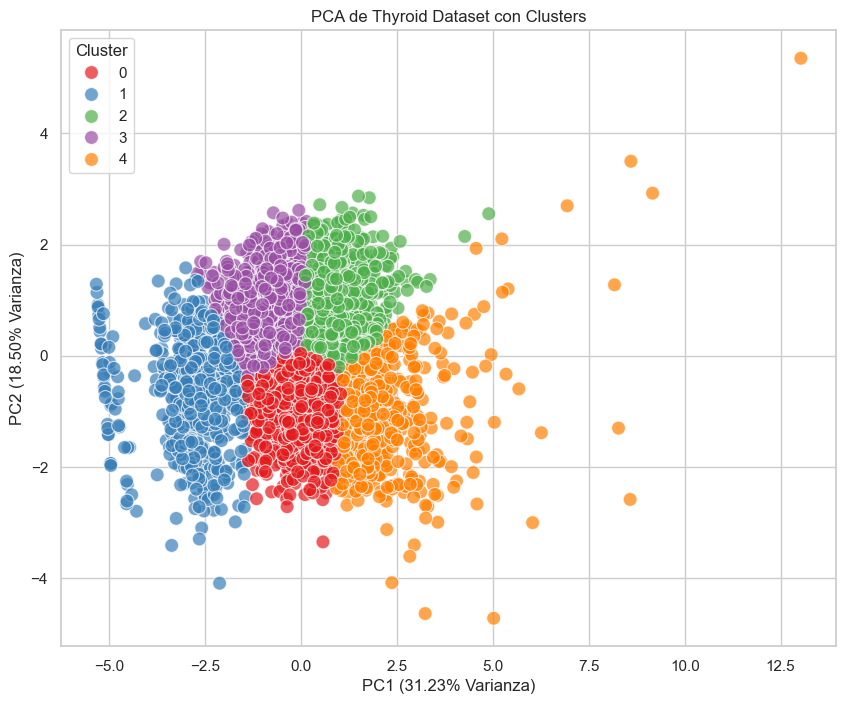

In [253]:
# Clustering con K-Means sobre PCA.
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Añadir clusters al DataFrame.
pca_df['Cluster'] = clusters

# Visualizar PCA con Clusters.
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA de Thyroid Dataset con Clusters')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

## **PCA con Variables Binarias.**
En algunos casos, es posible aplicar PCA a variables binarias (codificadas como 0 y 1), especialmente si se desea explorar la estructura subyacente o **reducir la dimensionalidad cuando hay muchas variables binarias** (por ejemplo, tras aplicar one-hot encoding). Sin embargo, se debe tener en cuenta que las **variables binarias aportan menos varianza y pueden distorsionar los resultados** si no se tratan con cuidado. Por eso, es recomendable revisar su distribución y asegurarse de que tienen suficiente variabilidad antes de incluirlas en el análisis.

In [254]:
print(f"Variables continuas seleccionadas para PCA: {continuous_cols}")
print(f"Variables binarias detectadas: {binary_cols}")

Variables continuas seleccionadas para PCA: ['age', 'hypopi1ui1ary', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
Variables binarias detectadas: ['on_1hyroxine', 'query_on_1hyroxine', 'on_an1i1hyroid_meds', 'sick', 'pregnan1', '1hyroid_surgery', 'I131_1rea1men1', 'query_hypo1hyroid', 'query_hyper1hyroid', 'li1hium', 'goi1re', '1umor', 'psych', 'target_thyro']


### **Tratamiento de variables continuas.**

In [255]:
# Preparación de datos.
df_continuous = df[continuous_cols].dropna()

# Estandarizar variables continuas.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_continuous)

### **Tratamiento de variables binarias.**

In [256]:
# Convertir variables binarias sin cambiar su escala.
df_binary = df[binary_cols].astype(float) if binary_cols else None

# Concatenar datos escalados.
if df_binary is not None:
    X_final = np.hstack((X_scaled, df_binary.values))
    feature_names = continuous_cols + binary_cols
else:
    X_final = X_scaled
    feature_names = continuous_cols

### **Realización PCA.**

In [257]:
# Aplicación PCA
n_components = 2  # Ajusta este número según necesidades
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_final)

# Crear DataFrame con los componentes principales.
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

In [258]:
# Obtención de la varianza explicada.
varianza_explicada = pca.explained_variance_ratio_

# Mostrar varianza explicada
for i, var in enumerate(varianza_explicada, start=1):
    print(f"PC{i}: {var*100:.2f}% de la varianza explicada")
print(f"Varianza total explicada: {sum(varianza_explicada)*100:.2f}%")

PC1: 28.68% de la varianza explicada
PC2: 16.93% de la varianza explicada
Varianza total explicada: 45.61%


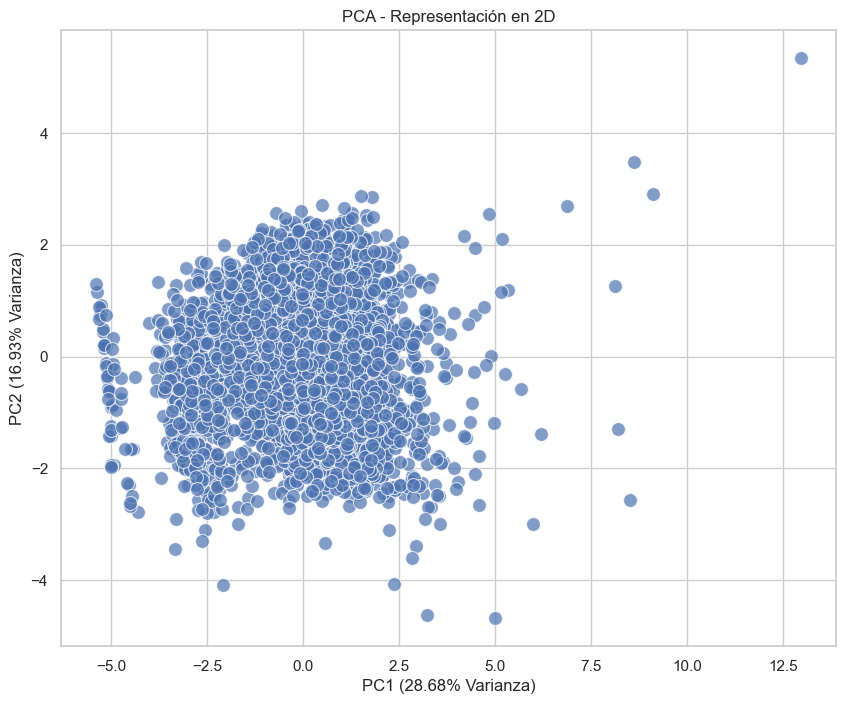

In [259]:
# Visualización: Scatter Plot de PCA.
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, alpha=0.7)
plt.title('PCA - Representación en 2D')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

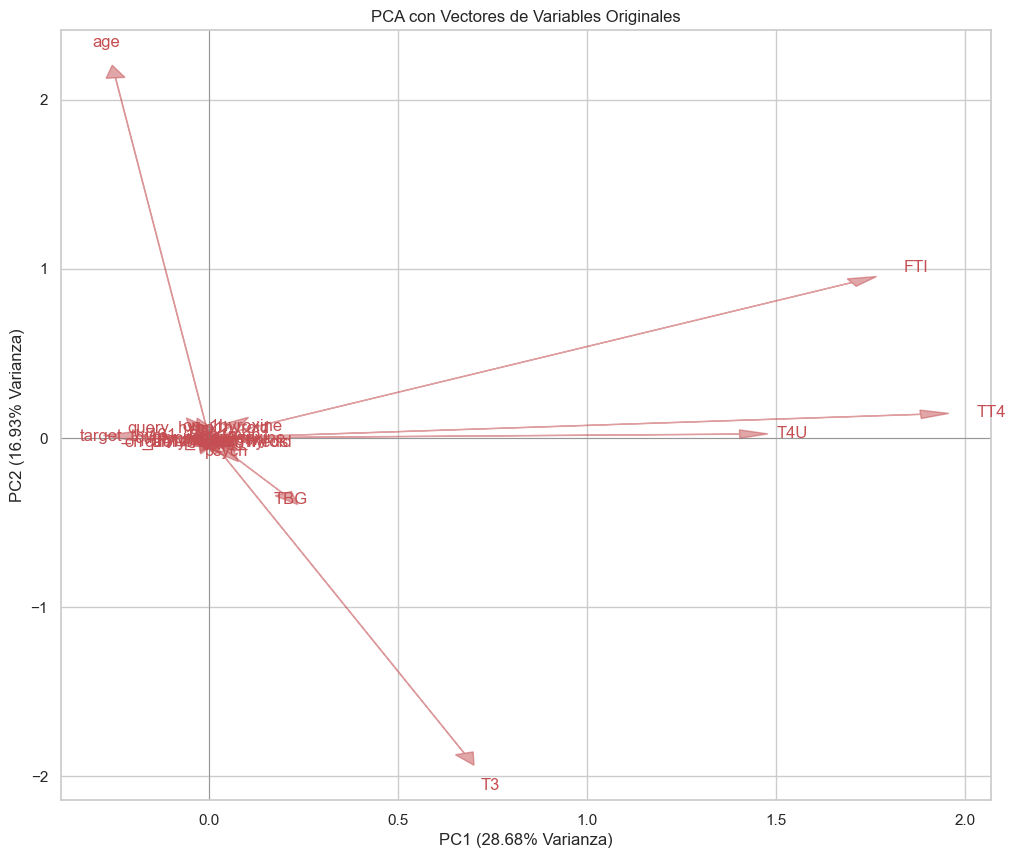

In [260]:
# Visualización: Biplot.
cargas = pca.components_.T
escalamiento = 3 # Ajusta este valor según los datos --> ampliar las flechas de los vectores.
cargas_scaled = cargas * escalamiento

plt.figure(figsize=(12, 10))
for i, var in enumerate(feature_names):
    plt.arrow(0, 0, cargas_scaled[i, 0], cargas_scaled[i, 1],
            color='r', alpha=0.5, head_width=0.05)
    plt.text(cargas_scaled[i, 0]*1.1, cargas_scaled[i, 1]*1.1,
            var, color='r', ha='center', va='center')

plt.title('PCA con Vectores de Variables Originales')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()

In [261]:
# DataFrame de Cargas.
cargas_df = pd.DataFrame(cargas, index=feature_names, columns=['PC1', 'PC2'])
print("Cargas de las variables en las componentes principales:")
cargas_df

Cargas de las variables en las componentes principales:


PC1       PC2
age                 -8.261336e-02  0.709655
hypopi1ui1ary       -2.220446e-16 -0.000000
T3                   2.249119e-01 -0.621624
TT4                  6.271732e-01  0.046492
T4U                  4.676339e-01  0.007506
FTI                  5.664685e-01  0.306209
TBG                  6.529086e-02 -0.109820
on_1hyroxine         1.841287e-02  0.021617
query_on_1hyroxine   2.351813e-04  0.000049
on_an1i1hyroid_meds -1.775197e-03 -0.007418
sick                -4.055882e-03  0.014980
pregnan1             8.151856e-03 -0.007836
1hyroid_surgery     -1.056856e-03 -0.003879
I131_1rea1men1      -1.527872e-03  0.004481
query_hypo1hyroid   -8.781556e-03  0.017149
query_hyper1hyroid   6.844845e-03 -0.007598
li1hium              3.956723e-04 -0.003928
goi1re               1.340538e-03 -0.004954
1umor                1.383480e-03 -0.008167
psych                1.367943e-02 -0.024837
target_thyro        -6.832972e-02  0.003523

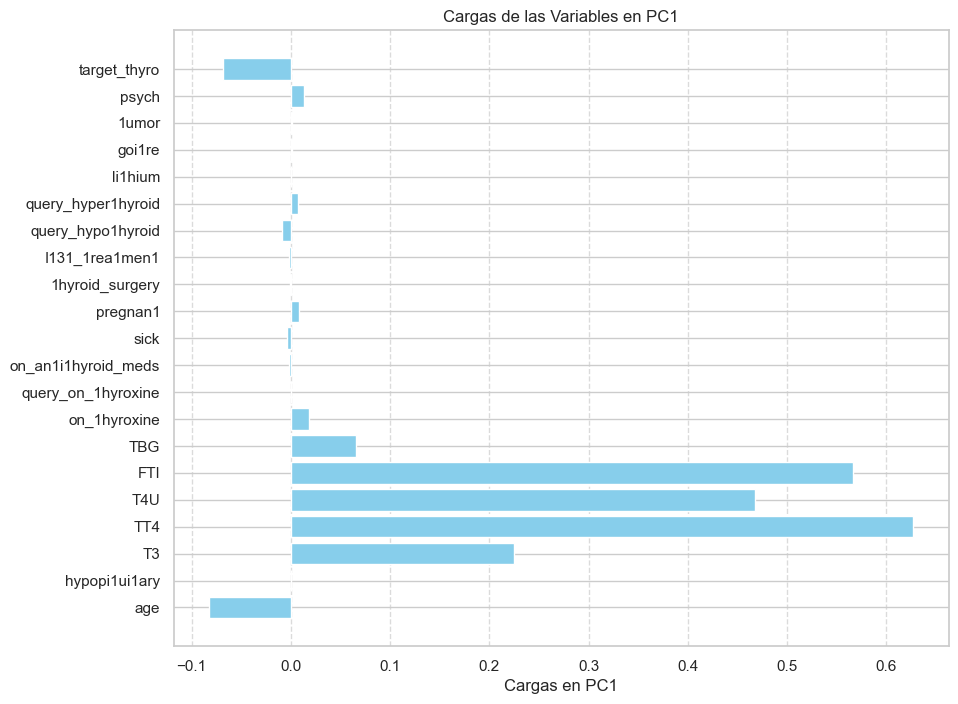

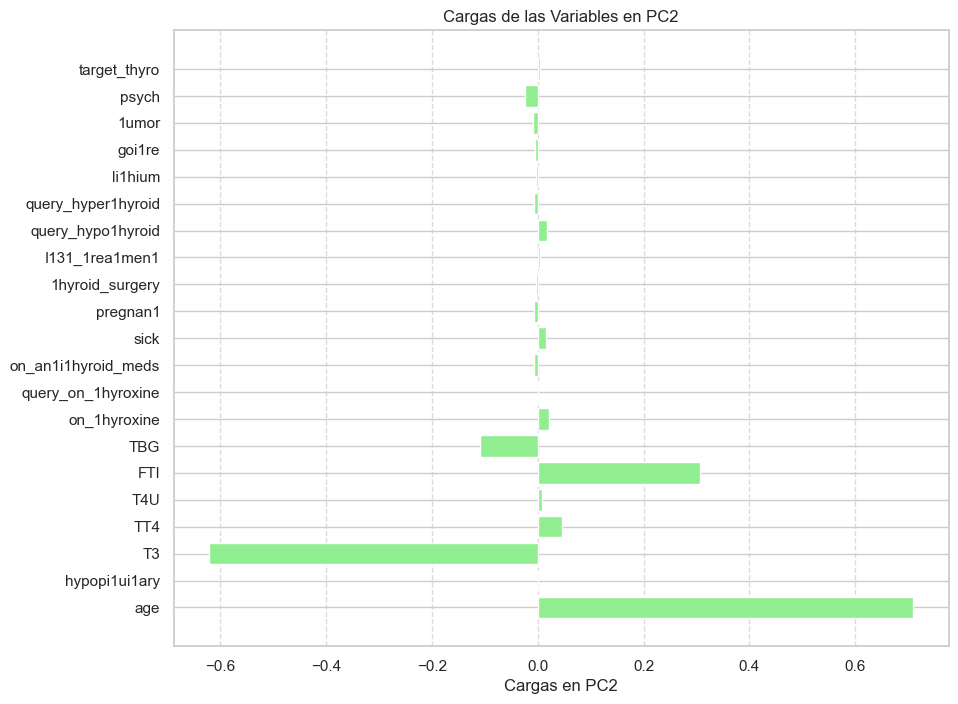

In [262]:
# Visualización: Cargas en PC1 y PC2
for pc in ['PC1', 'PC2']:
    plt.figure(figsize=(10, 8))
    plt.barh(cargas_df.index, cargas_df[pc], color='skyblue' if pc == 'PC1' else 'lightgreen')
    plt.xlabel(f'Cargas en {pc}')
    plt.title(f'Cargas de las Variables en {pc}')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

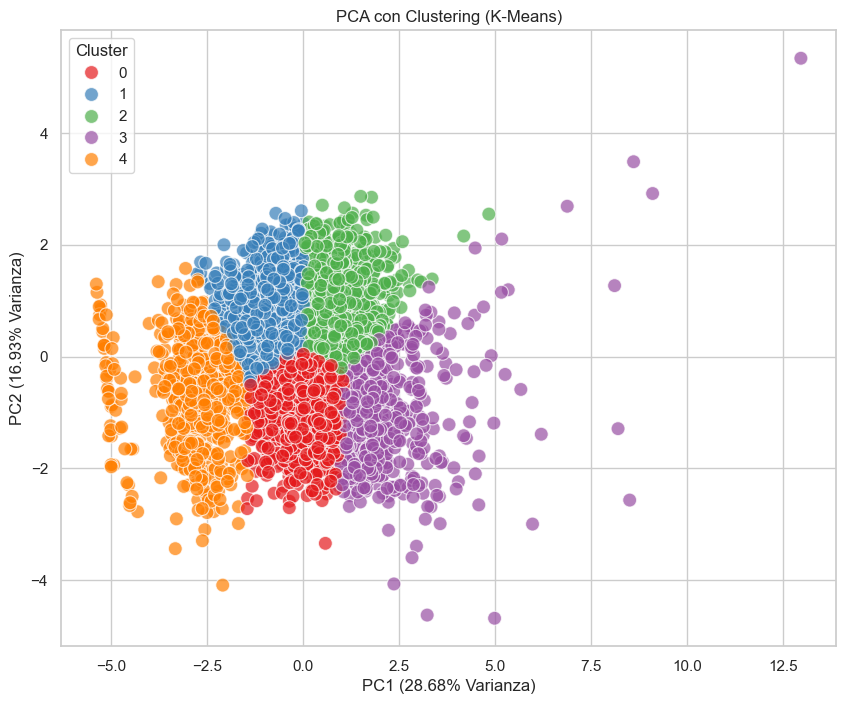

In [263]:
# Agrupamiento con K-Means.
num_clusters = 5  # Ajusta según los datos
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Añadir clusters al DataFrame.
pca_df['Cluster'] = clusters

# Visualización: PCA con Clusters.
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA con Clustering (K-Means)')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

## **T-SNE: T-Distributed Stochastic Neighbor Embedding.**
**T-SNE (t-distributed Stochastic Neighbor Embedding)** es una técnica de reducción de dimensionalidad especialmente útil para **visualizar datos de alta dimensión** en 2D o 3D. A diferencia del PCA, que busca proyectar los datos maximizando la varianza global, t-SNE se enfoca en **preservar la estructura local de los datos**, es decir, mantener **la proximidad entre puntos similares**.

**Características de t-SNE:**
- No es una técnica lineal como el PCA.
- Ideal para **explorar clústeres** u observar la separación entre grupos en los datos.
- Utiliza **distancias probabilísticas** para preservar relaciones de vecindad.
- Muy sensible al parámetro `perplexity` y a la inicialización.

**Diferencias clave con PCA:**
| Aspecto                | PCA                              | t-SNE                                      |
|------------------------|----------------------------------|--------------------------------------------|
| Tipo de técnica        | Lineal                           | No lineal                                  |
| Objetivo               | Maximizar varianza global        | Preservar vecindad local                   |
| Interpretabilidad      | Alta (combinaciones lineales)    | Baja (transformación compleja)            |
| Velocidad              | Rápido                           | Más lento (especialmente en datasets grandes) |
| Uso principal          | Reducción de dimensiones interpretables | Visualización de patrones complejos |

In [264]:
print("Variables continuas seleccionadas para t-SNE:", continuous_cols)

Variables continuas seleccionadas para t-SNE: ['age', 'hypopi1ui1ary', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']


In [265]:
# Selección solo de las variables numéricas continuas.
df_continuous = df[continuous_cols]

# Manejo de valores faltantes.
df_cleaned = df_continuous.dropna()

# Estandarizar las variables numéricas.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)

df_scaled = pd.DataFrame(X_scaled, columns=continuous_cols)
print("Datos estandarizados:")
df_scaled.head()

Datos estandarizados:


age  hypopi1ui1ary        T3       TT4       T4U       FTI       TBG
0 -1.246131            0.0  0.499894  0.841120 -3.180013 -2.457592 -0.061952
1 -1.298241            0.0  1.193645  0.467430 -3.180013 -2.457592 -0.061952
2 -1.298241            0.0  0.400787 -0.778203 -3.180013 -2.457592 -0.061952
3 -1.298241            0.0  0.301680 -0.560217 -3.180013 -2.457592 -0.061952
4  0.056598            0.0  0.896323  0.996824 -3.180013 -2.457592 -0.061952

Aplicamos el algoritmo T-SNE para reducir las dimensiones de los datos continuos estandarizados a 2D. Esto permite visualizar estructuras ocultas, agrupaciones o patrones complejos. T-SNE transforma los datos manteniendo relaciones locales (puntos similares quedan cerca). Es ideal para visualizar clústeres naturales que otros métodos no detectan fácilmente.

In [266]:
# Aplicar t-SNE.
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_components = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(data=tsne_components, columns=['t-SNE1', 't-SNE2'])

# Obtener todos los puntos del t-SNE.
tsne_points = tsne_df.values.tolist()

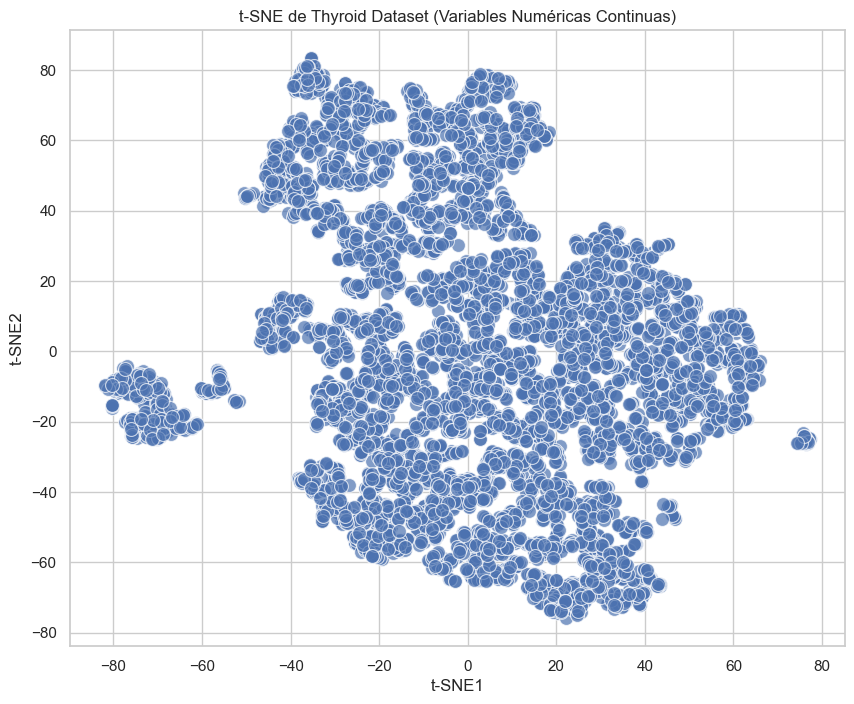

In [267]:
# Visualización: Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', data=tsne_df, s=100, alpha=0.7)
plt.title('t-SNE de Thyroid Dataset (Variables Numéricas Continuas)')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.grid(True)
plt.show()

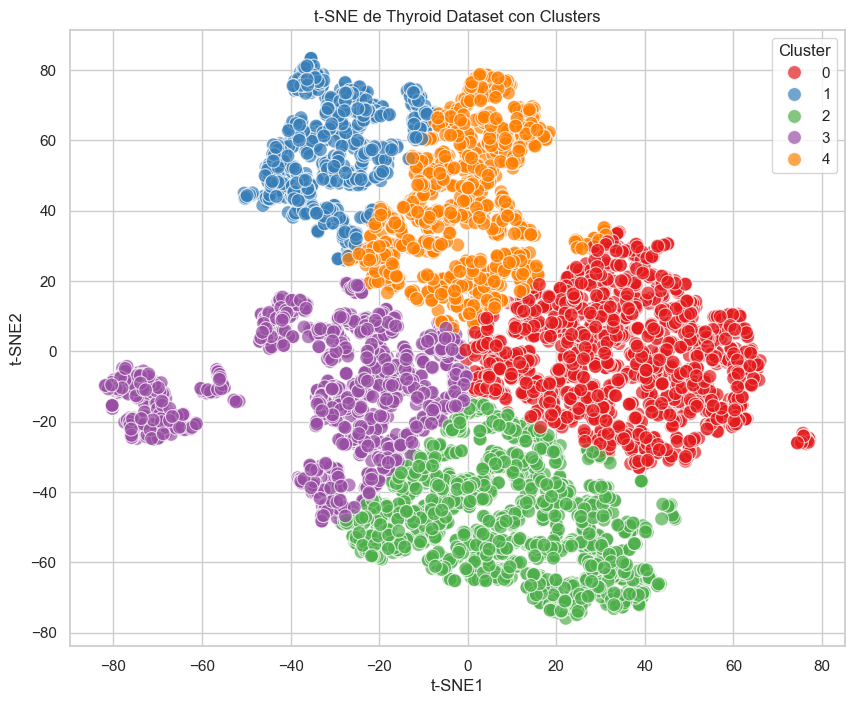

In [268]:
# Aplicar KMeans para clustering en t-SNE.
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(tsne_df[['t-SNE1', 't-SNE2']])

# Añadir clusters al DataFrame.
tsne_df['Cluster'] = clusters

# Visualización de Clusters.
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', data=tsne_df, palette='Set1', s=100, alpha=0.7)
plt.title('t-SNE de Thyroid Dataset con Clusters')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.grid(True)
plt.show()

Si lo comparamos con los resultados del **PCA**, el **t-SNE** ofrece una representación mucho más **expresiva** en términos de **agrupaciones visuales**. Mientras que el PCA proyecta los datos buscando **maximizar la varianza global**, su visualización tiende a mostrar una distribución **más compacta** y con cierta **superposición** entre puntos, lo que puede dificultar la identificación clara de clústeres. En cambio, **t-SNE logra separar de forma más evidente** regiones con **densidades diferenciadas**, lo que facilita detectar **estructuras ocultas** o **agrupaciones naturales** en el conjunto de datos. Esto se refleja especialmente al aplicar **K-Means**, donde los **clústeres obtenidos en el espacio t-SNE** resultan visualmente **más definidos y compactos** que en el espacio PCA. Por tanto, aunque t-SNE **no permite interpretar los ejes** como combinaciones lineales de variables originales, sí proporciona una **mejor representación para el análisis exploratorio visual** cuando se busca descubrir **patrones complejos**.

### **Visualización t-SNE coloreado por variables originales.**
En este paso, se representan los puntos proyectados en el espacio t-SNE, pero coloreando los puntos según los valores de distintas variables originales (por ejemplo, edad o resultados hormonales). Esto permite **observar si existe alguna relación visual o agrupación entre las variables reales y la proyección t-SNE.**

Nos ayuda a identificar si ciertas variables están relacionadas con las regiones del espacio t-SNE, lo que sugiere que pueden estar influyendo en los agrupamientos visuales.

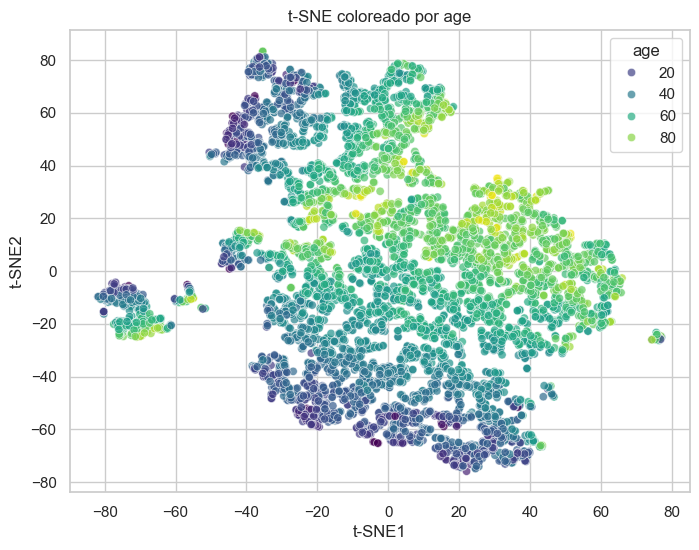

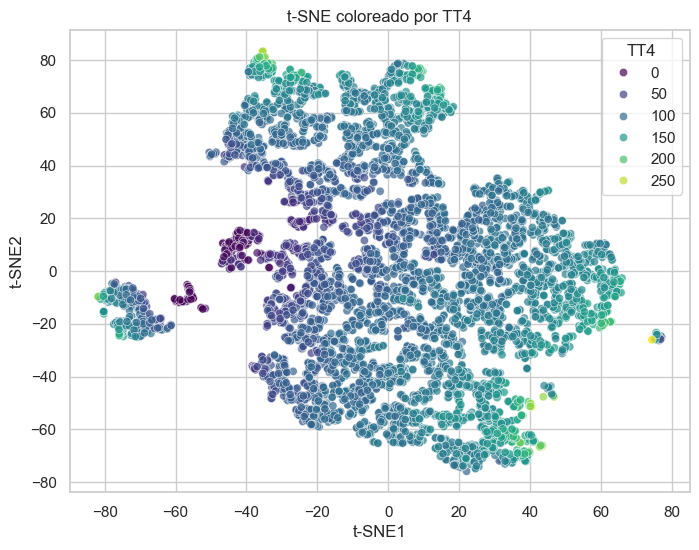

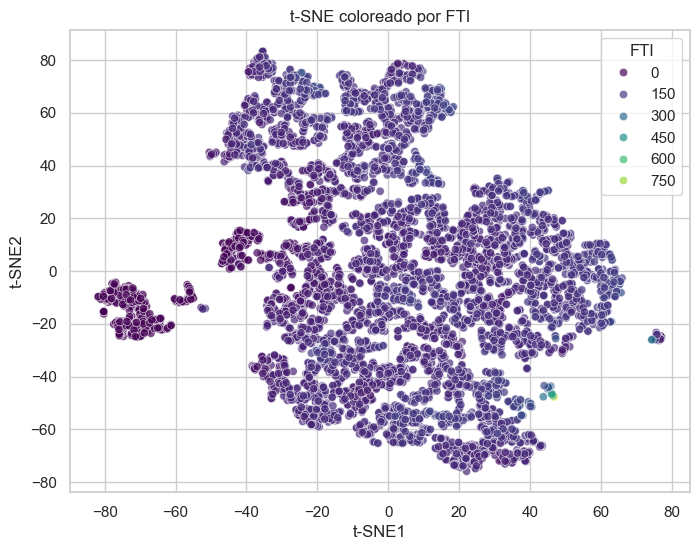

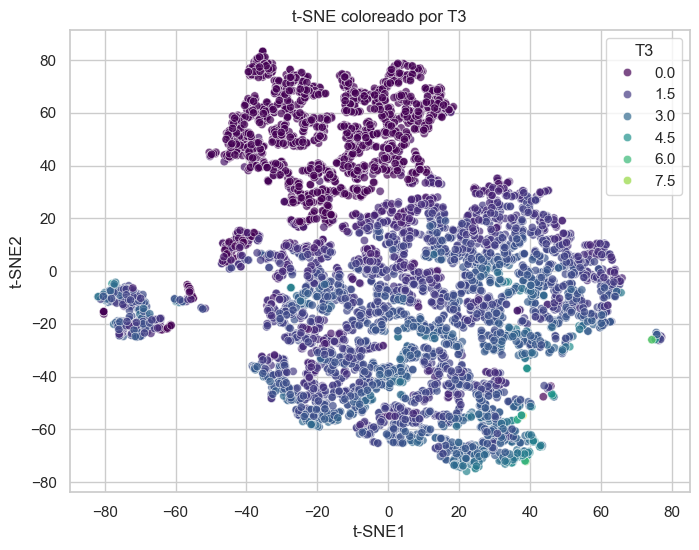

In [269]:
variables_a_visualizar = ['age', 'TT4', 'FTI', 'T3']  # Selección de algunas variables clave.

for var in variables_a_visualizar:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_df['t-SNE1'], y=tsne_df['t-SNE2'], palette='viridis', alpha=0.7, hue = df[var])
    plt.title(f't-SNE coloreado por {var}')
    plt.show()

### **Correlación entre t-SNE y variables originales.**
Aquí se calcula la matriz de correlación entre las componentes del t-SNE (`t-SNE1`, `t-SNE2`) y las variables originales del dataset. Este análisis permite detectar **qué variables están estadísticamente más relacionadas con las dimensiones generadas por t-SNE.**

Para cuantificar cómo se relacionan las variables reales con las nuevas dimensiones t-SNE. Las correlaciones más altas indican variables que pueden estar influyendo más en la distribución de los puntos.

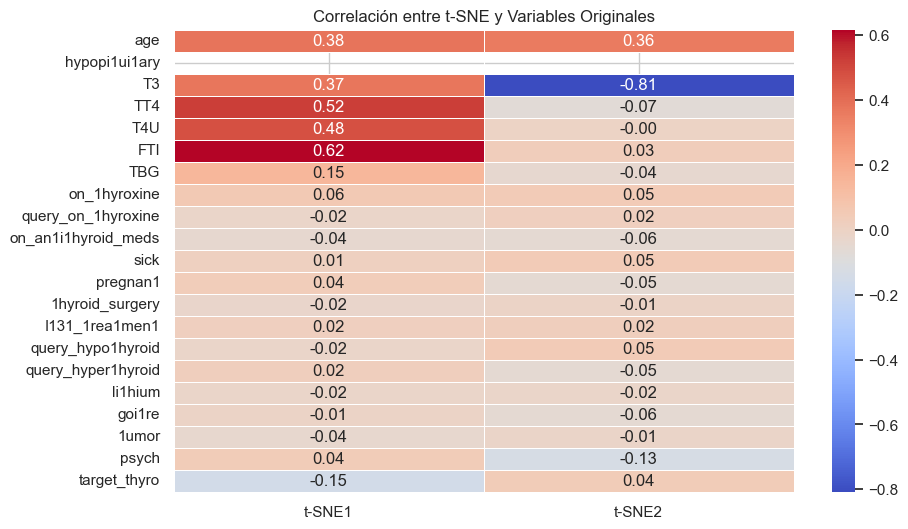

In [270]:
df_tsne_corr = pd.concat([tsne_df, df[continuous_cols + binary_cols]], axis=1)

# Calcular correlación.
correlaciones = df_tsne_corr.corr().loc[continuous_cols + binary_cols, ['t-SNE1', 't-SNE2']]

# Visualización de la matriz de correlación.
plt.figure(figsize=(10, 6))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlación entre t-SNE y Variables Originales')
plt.show()

### **Importancia de variables usando Árbol de Decisión.**
Entrenamos dos modelos de árboles de decisión para predecir **t-SNE1** y **t-SNE2** a partir de las variables originales. A partir de estos modelos, se calcula la importancia media de cada variable, es decir, cuánto ayuda cada variable a explicar la distribución en el espacio t-SNE.

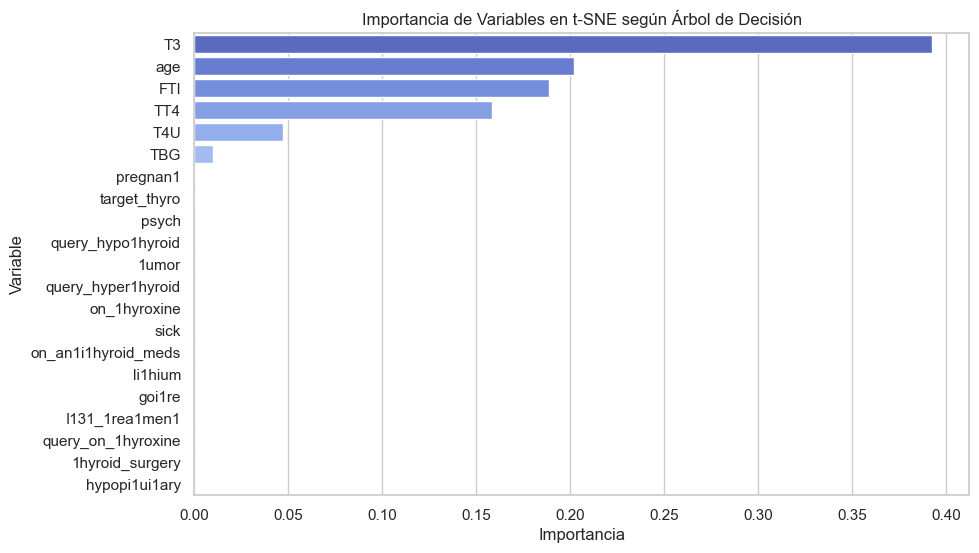

In [271]:
X = df[continuous_cols + binary_cols]  # Variables originales.
y_tsne1, y_tsne2 = tsne_df['t-SNE1'], tsne_df['t-SNE2'] # Objetivos t-SNE.

# Entrenar árboles de decisión para predecir t-SNE1 y t-SNE2.
model1 = DecisionTreeRegressor().fit(X, y_tsne1)
model2 = DecisionTreeRegressor().fit(X, y_tsne2)

# Obtener importancia de las variables.
feature_importance = (model1.feature_importances_ + model2.feature_importances_) / 2
importancia_df = pd.DataFrame({'Variable': X.columns, 'Importancia': feature_importance})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

# Visualización.
plt.figure(figsize=(10, 6))
sns.barplot(data=importancia_df, x='Importancia', y='Variable', hue='Variable', palette='coolwarm', dodge=False, legend=False)
plt.title('Importancia de Variables en t-SNE según Árbol de Decisión')
plt.show()

Este análisis ayuda a identificar qué variables explican mejor la forma del espacio t-SNE, es decir, cuáles son responsables de las agrupaciones o separaciones vistas en el mapa. Es útil cuando no se puede interpretar directamente el t-SNE, pero se quiere rastrear el origen de los patrones visuales.

### **Comparación entre el análisis de vectores en PCA y la importancia de variables en t-SNE.**

En el análisis de **PCA**, pudimos interpretar de forma directa la influencia de las variables originales mediante los **vectores de carga** (*loadings*), los cuales indican qué variables contribuyen más a la formación de cada componente principal. Por ejemplo, en nuestros resultados, observamos que variables como **FTI**, **TT4** o **T3** tenían cargas elevadas en las componentes principales, lo que sugiere que tienen un peso importante en la variabilidad del conjunto de datos.

En contraste, **t-SNE no permite calcular estas cargas**, ya que se trata de una técnica **no lineal** que no genera una fórmula explícita que relacione las variables originales con las nuevas dimensiones (`t-SNE1`, `t-SNE2`). Para entender qué variables están influyendo en la forma del espacio t-SNE, recurrimos a **métodos indirectos**, como:

- El cálculo de **correlaciones** entre `t-SNE1`/`t-SNE2` y las variables originales.
- El uso de **modelos de árbol de decisión** para estimar la **importancia relativa de cada variable** en la predicción de las coordenadas t-SNE.

Los resultados obtenidos por ambas vías en t-SNE fueron coherentes con el PCA: variables como **T3**, **FTI**, **TT4** y **age** aparecen como las más influyentes, lo que refuerza su rol clave en la estructuración de los datos. En cambio, las variables binarias relacionadas con historial clínico o tratamiento mostraron muy poca influencia en ambos casos.

> En resumen, aunque los enfoques son distintos, **ambos métodos coinciden en identificar las mismas variables clave**, siendo PCA más interpretable de forma matemática, y t-SNE más expresivo desde el punto de vista visual y exploratorio.

## **Embedding.**
Un **embedding** es una representación **numérica y compacta** de datos de alta dimensión en un espacio de menor dimensión. Se utiliza para **capturar las relaciones o similitudes** entre observaciones complejas de manera que puedan ser analizadas o visualizadas más fácilmente.

**Características principales:**
- Transforma datos (como texto, imágenes, categorías o datos tabulares) en **vectores numéricos**.
- Busca que **elementos similares estén cerca entre sí** en el nuevo espacio.
- Se utiliza ampliamente en técnicas de **reducción de dimensionalidad** (como PCA, t-SNE, UMAP) y en **aprendizaje profundo** (por ejemplo, en NLP con word embeddings como Word2Vec o BERT).

**En nuestro contexto (t-SNE y PCA):** Cuando aplicamos técnicas como PCA o t-SNE, lo que estamos obteniendo es un **embedding del dataset original** en un espacio de 2 o 3 dimensiones. Este nuevo espacio conserva, en la medida de lo posible:
- La **estructura global del dataset** (PCA).
- O las **relaciones locales o de vecindad** (t-SNE).

> En resumen: un embedding es una forma de **representar los datos de forma comprimida pero significativa**, ideal para visualización, análisis y aprendizaje automático.

In [272]:
# Identificar columnas numéricas y categóricas.
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Identificar variables binarias y continuas.
binary_cols = []
continuous_cols = []

for col in numerical_cols:
    unique_values = df[col].dropna().unique()
    if sorted(unique_values) == [0, 1]:
        binary_cols.append(col)
    else:
        continuous_cols.append(col)

# Excluir 'patient_id' si está presente.
if 'patient_id' in continuous_cols:
    continuous_cols.remove('patient_id')

Se codifican las categorías con LabelEncoder para convertirlas en números. Luego se entrena una pequeña red neuronal que aprende embeddings para esa variable. La red toma el valor codificado y aprende un vector que lo representa en un espacio numérico continuo.  Estos vectores son los embeddings, y los guarda como nuevas columnas en el dataset.

> El parámetro `embedding_dim = n` indica que cada categoría se representará como un vector de n dimensiones.

Una vez obtenidos los embeddings, se eliminan las columnas categóricas originales y se reemplazan por sus nuevas representaciones numéricas (los embeddings).

In [273]:
# Preprocesamiento de variables categóricas con Embeddings.
embedding_dim = 4  # Tamaño del embedding
categorical_embeddings = {}
encoded_dfs = []

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convertir categorías a números.
    vocab_size = len(le.classes_)  # Número de categorías únicas.

    # Crear embeddings con una red neuronal simple.
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1),
        Flatten(),
        Dense(embedding_dim, activation='relu')
    ])

    model.compile(optimizer=Adam(), loss='mse')

    X_train, X_test = train_test_split(df[col], test_size=0.2, random_state=42)
    model.fit(X_train, X_train, epochs=10, batch_size=16, verbose=0)
    
    # Obtener los embeddings.
    embeddings = model.layers[0].get_weights()[0]
    
    # Convertir a DataFrame.
    emb_df = pd.DataFrame(embeddings, columns=[f'{col}_emb_{i}' for i in range(embedding_dim)])
    emb_df[col] = range(vocab_size)
    categorical_embeddings[col] = emb_df
    
    # Agregar al dataframe.
    df = df.merge(emb_df, on=col, how='left')
    encoded_dfs.append(emb_df)

# Eliminar las columnas categóricas originales
df.drop(columns=categorical_cols, inplace=True)
df.head()

c:\Users\mgonzgarc\Documents\GitHub\gd_modelos\env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


age  on_1hyroxine  query_on_1hyroxine  on_an1i1hyroid_meds  sick  pregnan1  \
0   29             0                   0                    0     0         0   
1   28             0                   0                    0     0         0   
2   28             0                   0                    0     0         0   
3   28             0                   0                    0     0         0   
4   54             0                   0                    0     0         0   

   1hyroid_surgery  I131_1rea1men1  query_hypo1hyroid  query_hyper1hyroid  \
0                0               0                  0                   0   
1                0               0                  0                   0   
2                0               0                  0                   0   
3                0               0                  0                   0   
4                0               0                  0                   0   

   li1hium  goi1re  1umor  hypopi1ui1ary  psych  target_thyro   T3    TT4  \
0        0       0      0              0      0             0  1.9  128.0   
1        0       0      0              0      0             0  2.6  116.0   
2        0       0      0              0      0             0  1.8   76.0   
3        0       0      0              0      0             0  1.7   83.0   
4        0       0      0              0      0             0  2.3  133.0   

   T4U  FTI  TBG  patient_id  referral_source_emb_0  referral_source_emb_1  \
0  0.0  0.0    0   840801014              -0.995562               1.131490   
1  0.0  0.0    0   840807019               1.058895              -0.852831   
2  0.0  0.0    0   840808060              -0.995562               1.131490   
3  0.0  0.0    0   840808073              -0.995562               1.131490   
4  0.0  0.0    0   840810016              -0.995562               1.131490   

   referral_source_emb_2  referral_source_emb_3  
0              -1.020945              -1.302359  
1               0.741591              -0.670852  
2              -1.020945              -1.302359  
3              -1.020945              -1.302359  
4              -1.020945              -1.302359

In [274]:
# Seleccionar variables continuas y embeddings para PCA.
df_pca = df[continuous_cols + [f'{col}_emb_{i}' for col in categorical_embeddings for i in range(embedding_dim)]]

# Manejo de valores faltantes.
df_cleaned = df_pca.dropna()

# Estandarizar las variables numéricas.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)

Se aplica PCA a los datos numéricos incluyendo tanto variables continuas como embeddings para ver cómo se comportan juntos en un espacio reducido (2D).

In [275]:
# Aplicación PCA.
n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components+1)])

In [276]:
# Varianza explicada.
varianza_explicada = pca.explained_variance_ratio_
for i, var in enumerate(varianza_explicada, start=1):
    print(f"PC{i}: {var*100:.2f}%")
print(f"Varianza total explicada: {sum(varianza_explicada)*100:.2f}%")

PC1: 35.87%
PC2: 18.81%
Varianza total explicada: 54.68%


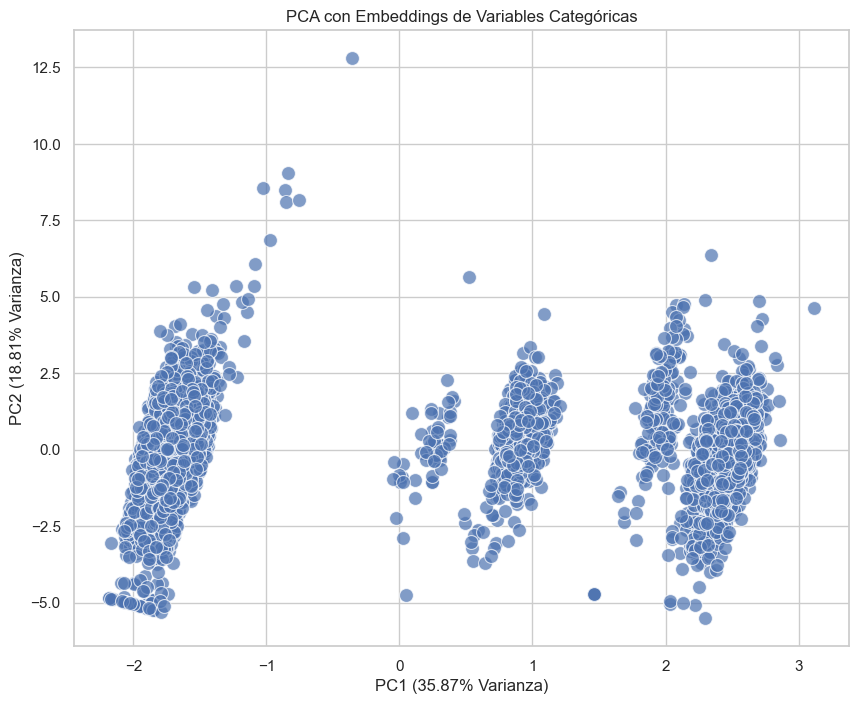

In [277]:
# Visualización: Scatter Plot.
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100, alpha=0.7)
plt.title('PCA con Embeddings de Variables Categóricas')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

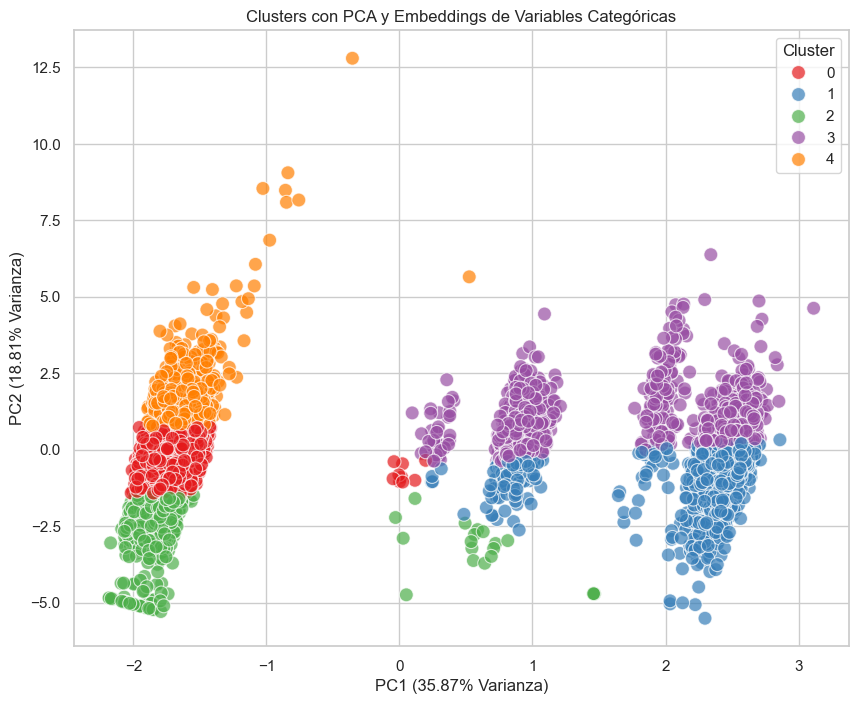

In [278]:
# Aplicar K-Means para clustering.
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])
pca_df['Cluster'] = clusters

# Visualizar Clusters.
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('Clusters con PCA y Embeddings de Variables Categóricas')
plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.2f}% Varianza)')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.2f}% Varianza)')
plt.grid(True)
plt.show()

## **LDA: Análisis Discriminante Lineal.**
**LDA (Análisis Discriminante Lineal)** es una técnica de **reducción de dimensionalidad supervisada**. A diferencia de PCA (que es no supervisado y solo busca varianza), **LDA tiene en cuenta las clases o etiquetas del problema** y busca proyectar los datos en un nuevo espacio donde **las clases estén lo más separadas posible**.

- **Reducir dimensiones** del dataset, igual que PCA.
- **Mejorar la separación entre clases** cuando se conoce la variable objetivo (etiquetas).
- **Visualizar datos clasificados** en 2D o 3D con mejor separación que con PCA.
- **Preprocesamiento para clasificación**: a veces LDA se usa antes de un clasificador como SVM o Logistic Regression.

**¿Cómo funciona?** LDA busca crear nuevas variables (llamadas *discriminantes lineales*) que:
- **Maximizan la distancia entre las medias de las clases**.
- **Minimizan la dispersión dentro de cada clase**.

En otras palabras, intenta encontrar un espacio donde las clases estén **bien separadas y agrupadas internamente**.

| Concepto             | PCA                                  | LDA                                     |
|----------------------|---------------------------------------|------------------------------------------|
| Tipo                 | No supervisado                        | Supervisado                              |
| Usa etiquetas        | No                                    | Sí                                     |
| Objetivo             | Maximizar varianza global             | Maximizar separación entre clases        |
| Interpretación       | Combinaciones de variables            | Combinaciones que separan clases         |
| Ideal para           | Exploración, reducción general        | Clasificación, análisis supervisado      |

In [279]:
# Verificar que target es binario y convertir si es necesario.
target_column = 'target_thyro'
if df[target_column].dtype == 'object' or df[target_column].dtype.name == 'category':
    print("Convirtiendo target a binario (0 = Normal, 1 = Hyper)...")
    df[target_column] = df[target_column].map({'normal': 0, 'hyper': 1})

# Asegurar que target solo tiene 0 y 1.
assert set(df[target_column].dropna().unique()) == {0, 1}, "Target debe ser solo 0 y 1."

In [280]:
# Separar variables predictoras (X) y variable objetivo (y).
X = df.drop(columns=[target_column])
y = df[target_column]

# Convertir variables categóricas a numéricas con OneHotEncoder.
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

if categorical_cols:
    print(f"Convirtiendo variables categóricas a numéricas: {categorical_cols}")
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_encoded = encoder.fit_transform(X[categorical_cols])
    
    # Crear DataFrame con las columnas codificadas.
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)
    
    # Eliminar las columnas categóricas originales y agregar las codificadas.
    X = X.drop(columns=categorical_cols)
    X = pd.concat([X, X_encoded_df], axis=1)

# Verificar si quedan valores no numéricos
assert X.select_dtypes(exclude=[np.number]).empty, "Aún quedan valores no numéricos en X."

# Normalizar las variables predictoras.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Aplica LDA y transforma el dataset a una única dimensión (LD1) que maximiza la separación entre las clases (por ejemplo, pacientes normales vs. con hipertiroidismo).

In [281]:
# Aplicar LDA (solo 1 componente para binario).
lda = LinearDiscriminantAnalysis(n_components=1)
lda_components = lda.fit_transform(X_scaled, y)

# Crear DataFrame con la proyección.
lda_df = pd.DataFrame(data=lda_components, columns=['LD1'])
lda_df['Clase'] = y

Muestra si las clases están bien separadas en la dimensión resultante. Si los puntos de clase 0 y clase 1 están agrupados en regiones distintas del eje Y, significa que LDA ha encontrado una buena proyección discriminante.

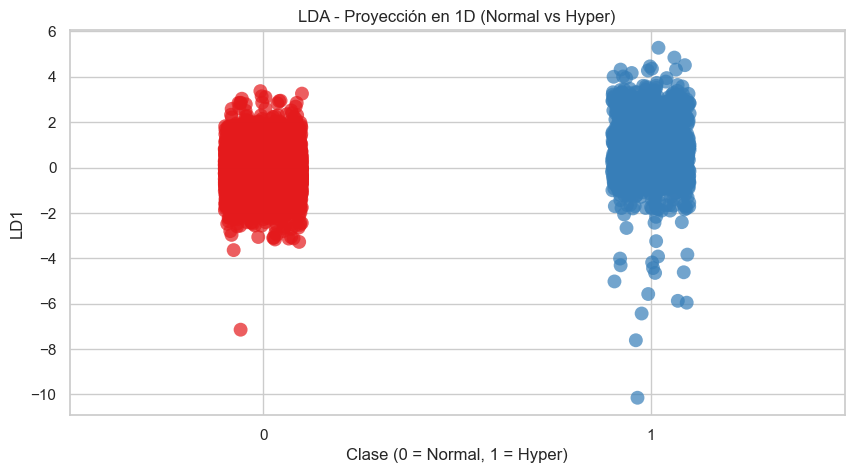

In [282]:
# Visualización en 1D.
plt.figure(figsize=(10, 5))
sns.stripplot(x='Clase', y='LD1', data=lda_df, hue='Clase', palette='Set1', jitter=True, size=10, alpha=0.7, legend=False)
plt.title('LDA - Proyección en 1D (Normal vs Hyper)')
plt.xlabel('Clase (0 = Normal, 1 = Hyper)')
plt.ylabel('LD1')
plt.grid(True)
plt.show()

Muestra cuánto contribuye cada variable a la separación entre clases. Las variables con coeficientes más altos son las que más ayudan a distinguir entre las clases. Es similar a los loadings en PCA.

In [283]:
#*Coeficientes de LDA (Cargas de las variables).
coeficientes = pd.DataFrame(lda.coef_.T, index=X.columns, columns=['LD1'])
coeficientes = coeficientes.sort_values(by='LD1', ascending=False)

print("Cargas de las variables en LD1:")
coeficientes

Cargas de las variables en LD1:


LD1
referral_source_emb_2  5.041177e+00
T4U                    3.449888e-01
on_1hyroxine           2.906039e-01
query_hypo1hyroid      2.251996e-01
query_on_1hyroxine     8.381272e-02
1hyroid_surgery        8.254576e-02
on_an1i1hyroid_meds    6.219280e-02
age                    5.473066e-02
TBG                    3.816659e-02
query_hyper1hyroid     3.411547e-02
I131_1rea1men1         2.669245e-02
li1hium                1.560532e-02
patient_id             1.558333e-02
hypopi1ui1ary          7.117088e-15
psych                 -2.676610e-02
pregnan1              -3.174541e-02
1umor                 -3.188674e-02
T3                    -4.939664e-02
sick                  -6.828099e-02
goi1re                -1.082460e-01
FTI                   -2.670017e-01
referral_source_emb_1 -4.974833e-01
TT4                   -6.376845e-01
referral_source_emb_3 -6.850447e-01
referral_source_emb_0 -5.076128e+00

Para ver visualmente qué variables están impulsando la separación entre grupos. Este gráfico es útil para interpretación y para seleccionar variables importantes.

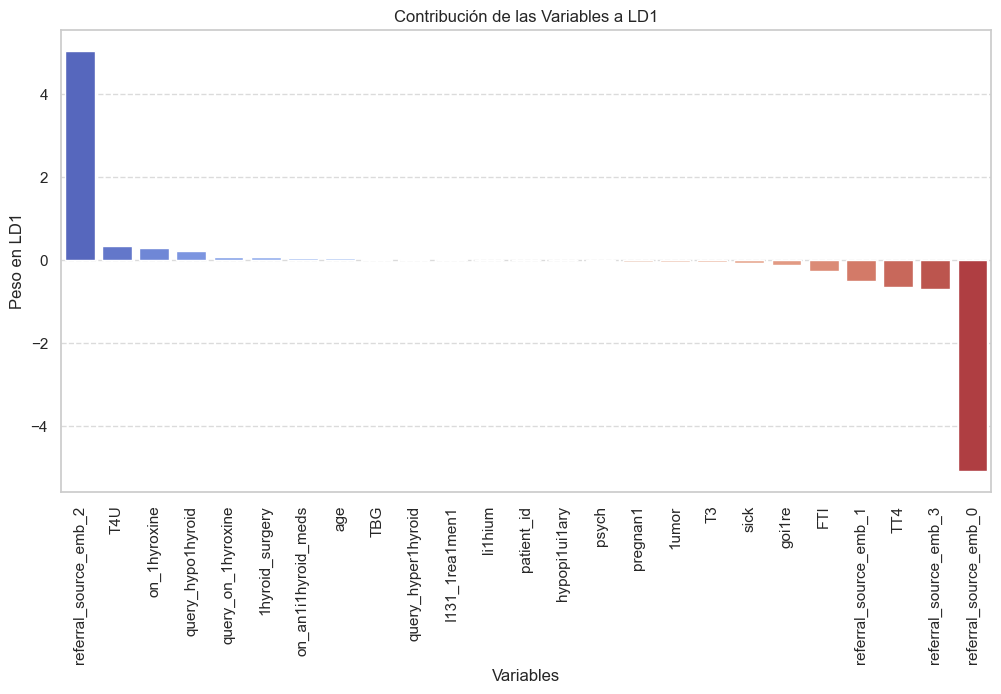

In [284]:
# Gráfico de las contribuciones de las variables.
plt.figure(figsize=(12, 6))
sns.barplot(x=coeficientes.index, y=coeficientes['LD1'], hue=coeficientes.index, palette='coolwarm', legend=False)
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('Peso en LD1')
plt.title('Contribución de las Variables a LD1')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

Es el porcentaje de información de clase que se conserva en LD1. Si es cercano al 100 %, quiere decir que LD1 es suficiente para separar las clases.

In [286]:
# Varianza explicada (Información retenida en LD1)
varianza_explicada = lda.explained_variance_ratio_
print(f"Varianza explicada por LD1: {varianza_explicada[0] * 100:.2f}%")

Varianza explicada por LD1: 100.00%


Son los autovectores asociados a la proyección LD1. Matemáticamente son similares a las cargas, pero usados internamente por LDA para transformar los datos.

In [287]:
# Obtención de los Autovectores (Eigenvectors).
autovectores = lda.scalings_
autovectores_df = pd.DataFrame(autovectores, index=X.columns, columns=['Autovector_LD1'])

print("Autovectores de LDA:")
autovectores_df

Autovectores de LDA:


Autovector_LD1
age                      6.195697e-02
on_1hyroxine             3.289735e-01
query_on_1hyroxine       9.487886e-02
on_an1i1hyroid_meds      7.040438e-02
sick                    -7.729642e-02
pregnan1                -3.593689e-02
1hyroid_surgery          9.344463e-02
I131_1rea1men1           3.021677e-02
query_hypo1hyroid        2.549337e-01
query_hyper1hyroid       3.861987e-02
li1hium                  1.766575e-02
goi1re                  -1.225382e-01
1umor                   -3.609688e-02
hypopi1ui1ary            8.056787e-15
psych                   -3.030014e-02
T3                      -5.591868e-02
TT4                     -7.218806e-01
T4U                      3.905391e-01
FTI                     -3.022551e-01
TBG                      4.320588e-02
patient_id               1.764086e-02
referral_source_emb_0   -5.746351e+00
referral_source_emb_1   -5.631681e-01
referral_source_emb_2    5.706785e+00
referral_source_emb_3   -7.754940e-01

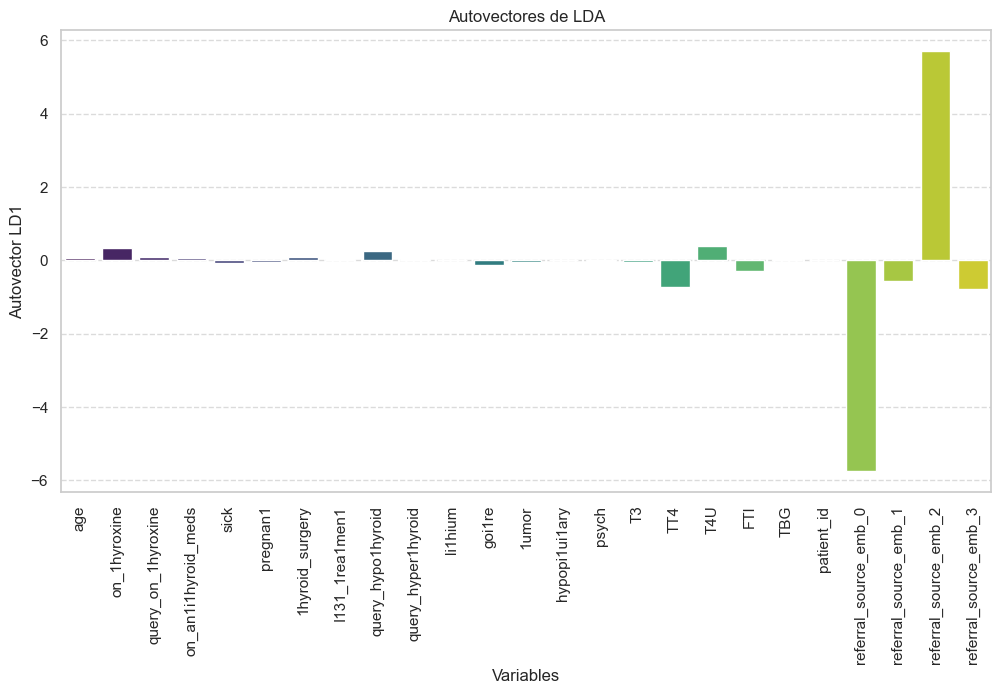

In [291]:
# Gráfico de los autovectores.
plt.figure(figsize=(12, 6))
sns.barplot(x=autovectores_df.index, y=autovectores_df['Autovector_LD1'], palette='viridis', legend=False, hue=autovectores_df.index)
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('Autovector LD1')
plt.title('Autovectores de LDA')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### **Interpretación de los resultados de LDA.**
Los coeficientes de LDA (LD1) indican qué variables son más importantes para separar las clases (normal vs hyper). Aquí está el análisis en detalle:

**¿Qué significan los valores de LD1?** Cada valor en la columna LD1 indica cuánto contribuye esa variable a la separación entre las clases 0 = normal y 1 = hyper:
- Valores positivos altos → Variables que empujan hacia la clase "hyper" (1).
- Valores negativos altos → Variables que empujan hacia la clase "normal" (0).
- Valores cercanos a 0 → Variables con poca influencia en la separación.
- Variables más importantes para distinguir entre "normal" y "hyper".
Las variables con los valores absolutos más altos en LD1 son las que más influyen en la separación de las clases.

**Variables que indican "hyper" (1).** Estas variables tienen LD1 positivo alto, por lo que aumentan la probabilidad de estar en la clase "hyper":

| **Variable**              | **LD1** |
|---------------------------|--------:|
| **TT4**                   |  0.637  |
| **FTI**                   |  0.267  |
| **referral_source_SVHC** |  0.192  |
| **goitre**                |  0.108  |
| **sick**                  |  0.068  |

Conclusión: Si una persona tiene valores altos en TT4, FTI o ha sido referida desde SVHC, es más probable que sea clasificada como "hyper".

**Variables que indican "normal" (0)**
Estas variables tienen LD1 negativo alto, lo que significa que disminuyen la probabilidad de ser "hyper" y aumentan la probabilidad de ser "normal":

| **Variable**                | **LD1**   |
|-----------------------------|----------:|
| **T4U**                     |  -0.344   |
| **on_thyroxine**            |  -0.291   |
| **query_hypothyroid**       |  -0.225   |
| **query_on_thyroxine**      |  -0.083   |
| **thyroid_surgery**         |  -0.082   |


Conclusión: Valores altos de T4U o estar en on_thyroxine disminuyen la probabilidad de ser "hyper" y aumentan la de ser "normal".

**¿Qué hacer con esta información?**
- Confirmar con expertos en el dominio si estas variables son relevantes para la clasificación entre hipertiroidismo y normalidad.
- Validar con más datos o modelos si estas variables siguen siendo significativas.
- Mejorar el modelo quitando variables que tienen valores cercanos a 0 (poca influencia) para evitar ruido en el modelo.

### **Aplicar LDA con hiperparámetros personalizados.**
En esta sección se aplica **Linear Discriminant Analysis (LDA)** utilizando una configuración avanzada con hiperparámetros personalizados. A diferencia del modelo básico, esta versión permite controlar aspectos clave del algoritmo, como el **tipo de resolución, la regularización y la tolerancia de convergencia**. Esta configuración es especialmente útil en contextos donde el dataset tiene muchas variables, presencia de ruido, o riesgo de sobreajuste. Además, se activa la opción de almacenar la matriz de covarianza para análisis posteriores.

El objetivo es obtener una proyección más robusta y estable del espacio discriminante, mejorando la capacidad de separación entre clases y facilitando la interpretación de las variables más influyentes.

In [ ]:
lda = LinearDiscriminantAnalysis(
    solver='lsqr',          # Algoritmo de cálculo ('svd', 'lsqr', 'eigen').
    shrinkage='auto',       # Regularización automática.
    priors=None,            # Estimación automática de probabilidades de clase.
    n_components=1,         # Reducir a 1 dimensión (obligatorio para binario).
    store_covariance=True,  # Guardar matriz de covarianza.
    tol=1e-4                # Tolerancia para convergencia.
)

# Entrenar LDA y transformar datos.
lda_components = lda.fit(X_scaled, y)

# Ver hiperparámetros usados en el modelo.
print("Hiperparámetros del modelo:")
print(lda.get_params())

Hiperparámetros del modelo:
{'covariance_estimator': None, 'n_components': 1, 'priors': None, 'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': True, 'tol': 0.0001}


## **Clustering Jerárquico.**
El Clustering Jerárquico es una técnica de aprendizaje no supervisado que busca agrupar observaciones similares **sin necesidad de definir el número de grupos desde el inicio**. A diferencia de K-Means, que requiere que digamos cuántos clústeres queremos, el clustering jerárquico construye una estructura en forma de árbol (dendrograma) que representa todas las posibles agrupaciones. Hay dos enfoques principales:

1. **Agglomerative (Ascendente)**
   - Parte con cada punto como su propio clúster.
   - Luego **va fusionando los más cercanos** paso a paso, hasta que todos forman un único grupo.
   - Es el más usado y el que suele implementarse por defecto.

2. **Divisive (Descendente)**
   - Parte de un solo grupo y **va dividiendo** en clústeres más pequeños.
   - Menos común y más costoso computacionalmente.

**¿Cuándo usar Clustering Jerárquico?**
- Cuando no se conoce el número de clústeres de antemano.
- Cuando se quiere **analizar relaciones jerárquicas** entre observaciones.
- En datasets **pequeños o medianos** (puede ser lento para miles de puntos).
- Para generar **agrupaciones interpretables visualmente**.

In [ ]:
# Seleccionar columnas numéricas.
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Identificar variables binarias y continuas.
binary_cols = []
continuous_cols = []

for col in numerical_cols:
    if col != 'patient_id':  # Excluir 'patient_id'
        unique_values = df[col].dropna().unique()
        if sorted(unique_values) == [0, 1]:
            binary_cols.append(col)
        else:
            continuous_cols.append(col)

df_continuous = df[continuous_cols]

print("Variables continuas seleccionadas para Clustering Jerárquico:", continuous_cols)

Variables continuas seleccionadas para Clustering Jerárquico: ['age', 'hypopi1ui1ary', 'T3', 'TT4', 'T4U', 'FTI', 'TBG', 'referral_source_emb_0', 'referral_source_emb_1', 'referral_source_emb_2', 'referral_source_emb_3']


In [ ]:
# Manejo de valores faltantes.
df_cleaned = df_continuous.dropna()

# Verificar si df_cleaned está vacío antes de continuar.
if df_cleaned.empty:
    raise ValueError("Error: No hay suficientes datos después de eliminar valores faltantes. Prueba imputar valores en lugar de eliminarlos.")

# Estandarizar las variables numéricas.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)

df_scaled = pd.DataFrame(X_scaled, columns=continuous_cols)

print(f"Dimensión de df_cleaned: {df_cleaned.shape}")
print(f"Columnas seleccionadas: {continuous_cols}")
print("Datos estandarizados:")
df_scaled.head()

Dimensión de df_cleaned: (6210, 11)
Columnas seleccionadas: ['age', 'hypopi1ui1ary', 'T3', 'TT4', 'T4U', 'FTI', 'TBG', 'referral_source_emb_0', 'referral_source_emb_1', 'referral_source_emb_2', 'referral_source_emb_3']
Datos estandarizados:


age  hypopi1ui1ary        T3       TT4       T4U       FTI       TBG  \
0 -1.246131            0.0  0.499894  0.841120 -3.180013 -2.457592 -0.061952   
1 -1.298241            0.0  1.193645  0.467430 -3.180013 -2.457592 -0.061952   
2 -1.298241            0.0  0.400787 -0.778203 -3.180013 -2.457592 -0.061952   
3 -1.298241            0.0  0.301680 -0.560217 -3.180013 -2.457592 -0.061952   
4  0.056598            0.0  0.896323  0.996824 -3.180013 -2.457592 -0.061952   

   referral_source_emb_0  referral_source_emb_1  referral_source_emb_2  \
0              -0.817742               0.901792              -0.821561   
1               1.463880              -1.256622               1.440733   
2              -0.817742               0.901792              -0.821561   
3              -0.817742               0.901792              -0.821561   
4              -0.817742               0.901792              -0.821561   

   referral_source_emb_3  
0              -0.839076  
1               0.687382  
2              -0.839076  
3              -0.839076  
4              -0.839076

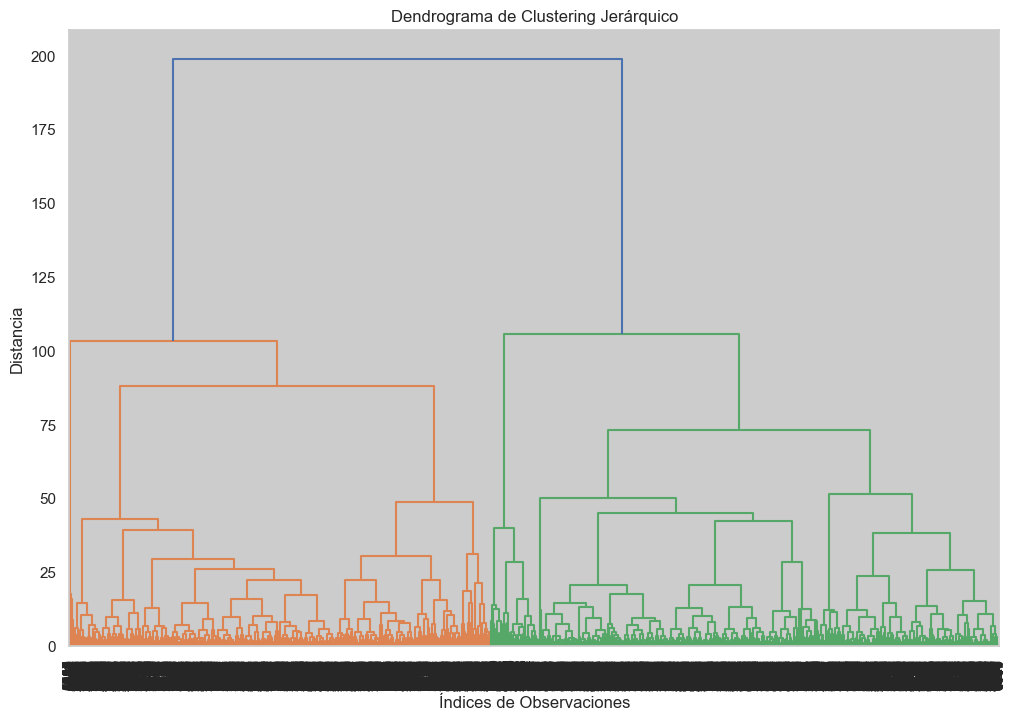

In [299]:
# Aplicar Clustering Jerárquico.
linkage_matrix = linkage(X_scaled, method='ward')  # Método Ward minimiza la varianza dentro de los clusters.

# Visualización del dendrograma.
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=df_cleaned.index, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma de Clustering Jerárquico")
plt.xlabel("Índices de Observaciones")
plt.ylabel("Distancia")
plt.grid(True)
plt.show()

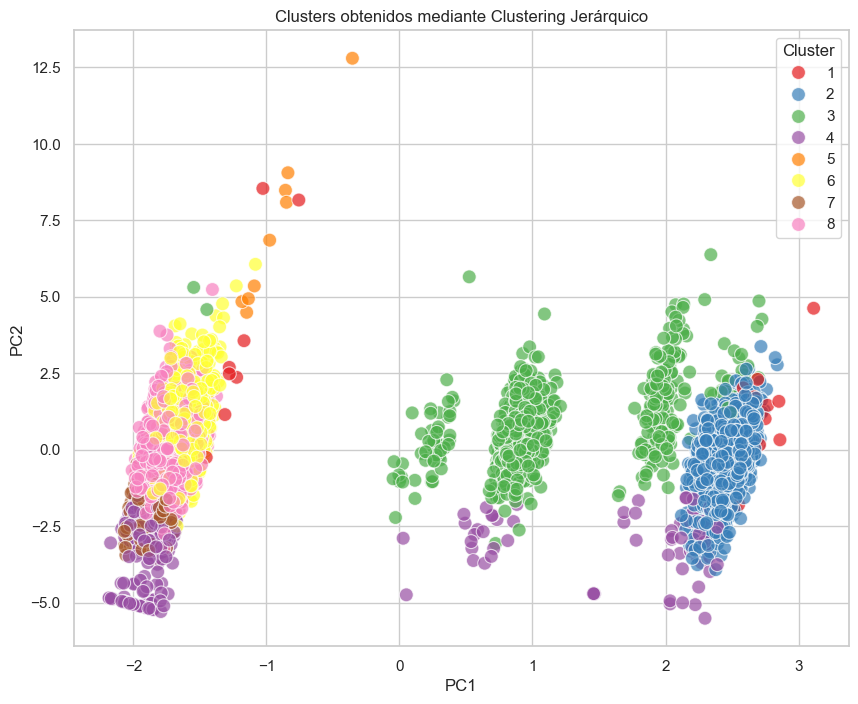

In [304]:
# Definir número de clusters y asignar etiquetas.
distance_threshold = 50  # Ajustar según el dendrograma.
clusters = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

df_cleaned['Cluster'] = clusters

# Visualización con Scatter Plot (Usamos PCA para reducir dimensiones a 2D para visualización).
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('Clusters obtenidos mediante Clustering Jerárquico')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()